# Scenario

Spark Funds is an asset management company. It wants to make investments in a few companies. The CEO of Spark Funds wants to understand the global trends in investments so that she can take the investment decisions effectively.

__Spark Funds has few minor constraints for investments:__

It wants to invest between 5 to 15 million USD per round of investment

It wants to invest only in English-speaking countries because of the ease of communication with the companies it would invest in.

It wants to choose one investment type from the 4 major types (Seed, Angel, Venture, Private Equity) for each potential investment they make. 

__What is the strategy?__

Spark Funds wants to invest where most other investors are investing. This pattern is often observed among early stage startup investors.

__Where did we get the data from?__

We have taken real investment data from crunchbase.com.

__Datasets:__

    Name: companies.csv
    Desc: A table with basic data of companies (Company details)

    Name: rounds2.csv
    Desc: Contains details about companies funding per round.

    Name: mapping.csv
    Desc: This file maps the numerous category names in the companies table (such 3D printing, aerospace, agriculture, etc.) to eight broad sector names. The purpose is to simplify the analysis into eight sector buckets, rather than trying to              analyse hundreds of them.

## Business objective

The objective is to identify the best sectors, countries, and a suitable investment type for making investments. The overall strategy is to invest where others are investing, implying that the 'best' sectors and countries are the ones 'where most investors are investing'.

### Importing Relevant Packages

In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

### Importing datasets

On observation we see that file is encoded using multiple encoding types (maybe because the ‘company_permalink’ column contains names of companies in various countries, and hence various languages).

In [2]:
# encoding specified to get rid of encoding issues for specific rows
companies = pd.read_csv("\\companies.txt", sep='\t', encoding="ISO-8859-1")
rounds2 = pd.read_csv("\\rounds2.csv", encoding="ISO-8859-1")
sect_map = pd.read_csv("\\mapping.csv")

In [3]:
companies.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


In [4]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
permalink        66368 non-null object
name             66367 non-null object
homepage_url     61310 non-null object
category_list    63220 non-null object
status           66368 non-null object
country_code     59410 non-null object
state_code       57821 non-null object
region           58338 non-null object
city             58340 non-null object
founded_at       51147 non-null object
dtypes: object(10)
memory usage: 5.1+ MB


In [5]:
companies.describe()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66102,61191,27296,4,137,311,1092,5111,3978
top,/Organization/Results-Scorecard,Spire,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


In [6]:
# Nan values for every column in Companies dataset
companies.isna().sum()

permalink            0
name                 1
homepage_url      5058
category_list     3148
status               0
country_code      6958
state_code        8547
region            8030
city              8028
founded_at       15221
dtype: int64

__*company_permalink column has upper/lower case entries. Should standardize it to lower case.*__

In [7]:
rounds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


In [8]:
# Nan values for every column in rounds2 dataset
rounds2.isna().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
dtype: int64

### Finding uniques and creating a combined MasterFrame

In [5]:
companies.permalink = companies.permalink.str.encode('utf-8').str.decode('ascii', 'ignore') # Removing problematic characters
companies.permalink = companies.permalink.apply(lambda x: x.lower())  # To lower

print(f"There are {companies.permalink.nunique()} unique rows in companies table.")

There are 66368 unique rows in companies table.


In [6]:
rounds2.company_permalink = rounds2.company_permalink.str.encode('utf-8').str.decode('ascii', 'ignore') # Removing problematic characters
rounds2.company_permalink = rounds2.company_permalink.apply(lambda x: x.lower()) # To lower


print(f"There are {companies.permalink.nunique()} unique rows in rounds2 table.")

There are 66368 unique rows in rounds2 table.


In [7]:
def check_for_equality(a, b):
    """
    Checks if all values between two Series/Dataframes are same.
    Returns disimilliar values if they or not.
    """

    seta = set(a.flatten())
    setb = set(b.flatten())
    print(f"A: {len(seta)}, B: {len(setb)}, Intersection: {len(seta.intersection(setb))}")
    if len(seta - setb) > 0:
        
        print(seta - setb)
        print(setb - seta)
        
    else: print("They are the same")
        
check_for_equality(companies.permalink.unique(), rounds2.company_permalink.unique())

A: 66368, B: 66368, Intersection: 66365
{'/organization/lawp d', '/organization/51wofang- ', '/organization/huizuche-com- '}
{'/organization/lawpd', '/organization/51wofang-', '/organization/huizuche-com-'}


__*Few names have unnecesary spaces*__

In [8]:
# Fixing spaces issue
companies.permalink = companies.permalink.str.replace(' ', '')
rounds2.company_permalink = rounds2.company_permalink.str.replace(' ', '')

check_for_equality(companies.permalink.unique(), rounds2.company_permalink.unique())

A: 66368, B: 66368, Intersection: 66368
They are the same


In [9]:
# Setting respective primary keys as index for both dataframes
companies.set_index('permalink', inplace=True)
rounds2.set_index('company_permalink', inplace=True)

In [10]:
# Creating Primary Key
master_frame = rounds2.join(companies)
print(f"There are {len(master_frame)} observations in master_frame.")

master_frame.head()

There are 114949 observations in master_frame.


,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007


### Finding average funding Amounts by Type

In [11]:
# Frequency of every type of funding
master_frame.funding_round_type.value_counts()

venture                  55494
seed                     30524
debt_financing            6895
angel                     6094
undisclosed               4897
equity_crowdfunding       3257
private_equity            2285
grant                     2200
convertible_note          1817
post_ipo_equity            638
product_crowdfunding       410
non_equity_assistance      191
post_ipo_debt              152
secondary_market            95
Name: funding_round_type, dtype: int64

In [12]:
# We can drop all rows which are not of type venture, seed, angel, private_equity
master_frame = master_frame[master_frame.funding_round_type.isin(['venture', 'seed', 'angel', 'private_equity'])]

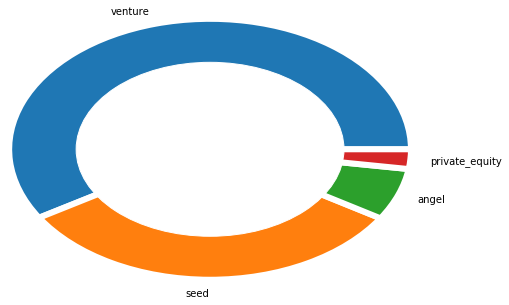

venture           55494
seed              30524
angel              6094
private_equity     2285
Name: funding_round_type, dtype: int64


In [46]:
round_types = master_frame.funding_round_type.value_counts()

# Create a pieplot
plt.pie(round_types.values, labels=round_types.index, radius=1.5, wedgeprops = { 'linewidth' : 6, 'edgecolor' : 'white' })

# add a circle at the center
my_circle=plt.Circle( (0,0), 1, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()
print(round_types)


In [49]:
# Average funding amount for venture type
venture_mean = master_frame[master_frame['funding_round_type']=='venture'].raised_amount_usd.mean()
print(f"Average funding amount raised: {round(venture_mean, 2)}")

Average funding amount raised: 11748949.13


In [50]:
# Average funding amount for angel type
angel_mean = master_frame[master_frame['funding_round_type']=='angel'].raised_amount_usd.mean()
print(f"Average funding amount raised: {round(angel_mean, 2)}")

Average funding amount raised: 958694.47


In [51]:
# Average funding amount for seed type
seed_mean = master_frame[master_frame['funding_round_type']=='seed'].raised_amount_usd.mean()
print(f"Average funding amount raised: {round(seed_mean, 2)}")

Average funding amount raised: 719818.0


In [52]:
# Average funding amount for private equity type
equity_mean = master_frame[master_frame['funding_round_type']=='private_equity'].raised_amount_usd.mean()
print(f"Average funding amount raised: {round(equity_mean, 2)}")

Average funding amount raised: 73308593.03


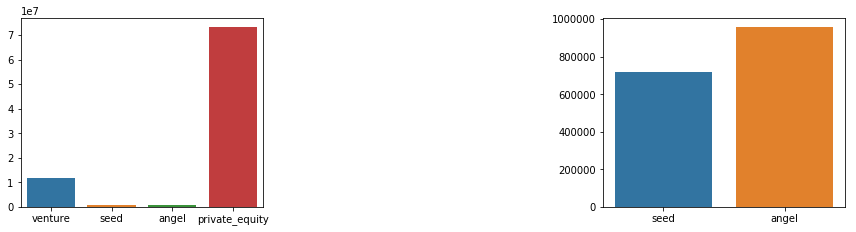

In [71]:
plt.figure(figsize=(20, 16))
ax1 = plt.subplot(4, 4, 1)
ax2 = plt.subplot(4, 4, 3)
sns.barplot(x=round_types.index, y=[venture_mean, seed_mean, angel_mean, equity_mean], ax=ax1)
sns.barplot(x=round_types.index[1:3], y=[seed_mean, angel_mean], ax=ax2)
plt.show()

In [22]:
# Finding ideal investment type
inv_dict = {'venture': venture_mean, 'angel': angel_mean, 'seed': seed_mean, 'equity': equity_mean}
for inv_type in inv_dict:
    if inv_dict[inv_type] > 5000000 and inv_dict[inv_type] < 15000000:
        print(f"Ideal investment type for Spark Funds is: {inv_type}")

Ideal investment type for Spark Funds is: venture


### Top English speaking countries to invest in  (with highest funding for chosen type)

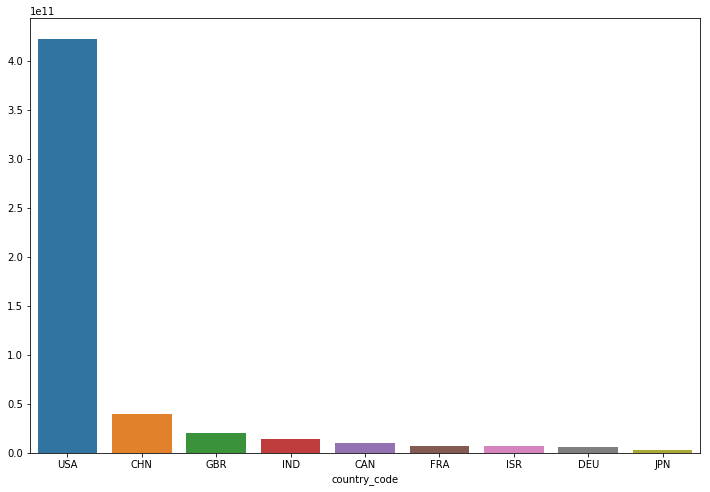

              raised_amount_usd
country_code                   
USA                4.225108e+11
CHN                3.983542e+10
GBR                2.024563e+10
IND                1.439186e+10
CAN                9.583332e+09
FRA                7.259537e+09
ISR                6.907515e+09
DEU                6.346960e+09
JPN                3.363677e+09 

Top 3 english speaking countries in order are: USA, GBR, IND


In [83]:
# top 9 countries with the highest venture type funding   
top9 = master_frame[master_frame['funding_round_type']=='venture'].groupby('country_code').sum().sort_values('raised_amount_usd', ascending=False).head(9)
plt.figure(figsize=(12, 8))
sns.barplot(x=top9.index, y=top9.values.ravel())
plt.show()

print(top9, '\n')
print("Top 3 english speaking countries in order are: USA, GBR, IND")

In [85]:
# Generating a Primary Sector Column
master_frame['primary_sector'] = 0
master_frame['primary_sector'] = master_frame['category_list'].str.split('|', expand=True)

In [86]:
# correcting improperly decoded words from mapping.csv
sect_map.reset_index(inplace=True)
sect_map['category_list'] = sect_map['category_list'].str.replace('0', 'na')

In [87]:
# set category_list as index column for mapping df
sect_map.set_index('category_list', inplace=True)
sect_map.drop('index', axis=1, inplace=True)

# Generate dictionary of [primary_sec: main_sec] pairs
sector_dict = {idx: next(k for k in sect_map if row[k]==1)
     for idx, row in sect_map.iterrows()}

In [89]:
# map the main sectors using sector_dictionary
master_frame['main_sector'] = master_frame['primary_sector'].map(sector_dict)

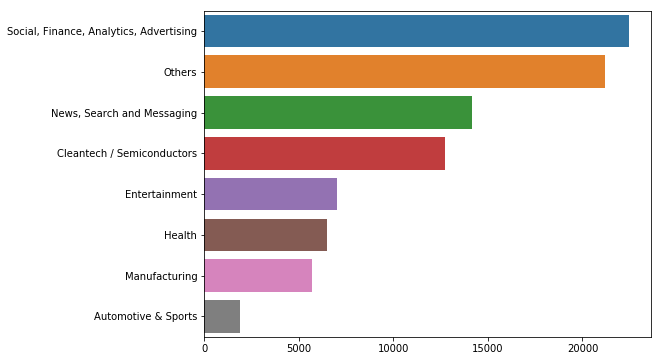

Social, Finance, Analytics, Advertising    22485
Others                                     21201
News, Search and Messaging                 14156
Cleantech / Semiconductors                 12712
Entertainment                               6991
Health                                      6487
Manufacturing                               5683
Automotive & Sports                         1883
Name: main_sector, dtype: int64


In [93]:
# Drop all rows which couldn't get mapped (and we drop blanks as there are only 8 sectors)
master_frame.dropna(subset=['main_sector'], inplace=True)
master_frame = master_frame[master_frame['main_sector'] != 'Blanks']
sectors = master_frame.main_sector.value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sectors.values, y=sectors.index)
plt.show()

print(sectors)

In [30]:
master_frame[['name','primary_sector', 'main_sector']].head(10)

,name,primary_sector,main_sector
/organization/-fame,#fame,Media,Entertainment
/organization/-qounter,:Qounter,Application Platforms,"News, Search and Messaging"
/organization/-qounter,:Qounter,Application Platforms,"News, Search and Messaging"
/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",Apps,"News, Search and Messaging"
/organization/0-6-com,0-6.com,Curated Web,"News, Search and Messaging"
/organization/004-technologies,004 Technologies,Software,Others
/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,Cleantech / Semiconductors
/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,Cleantech / Semiconductors
/organization/0xdata,H2O.ai,Analytics,"Social, Finance, Analytics, Advertising"
/organization/0xdata,H2O.ai,Analytics,"Social, Finance, Analytics, Advertising"


__*We will choose to ignore any existing Nan values instead of dropping them altogether*__ (As it changes certain properties such as entry counts)

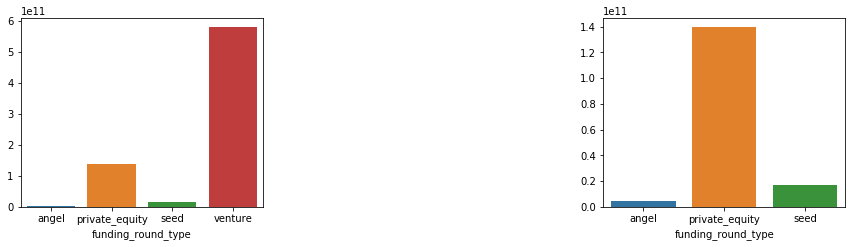

                    raised_amount_usd
funding_round_type                   
angel                    4.592013e+09
private_equity           1.396905e+11
seed                     1.672817e+10
venture                  5.808654e+11


In [97]:
# Aggregate of amount raised per round type
amount_per_type = master_frame.groupby('funding_round_type').agg({'raised_amount_usd': 'sum'})

plt.figure(figsize=(20, 16))
ax1 = plt.subplot(4, 4, 1)
ax2 = plt.subplot(4, 4, 3)

sns.barplot(x=amount_per_type.index, y=amount_per_type.values.ravel(), ax=ax1)
sns.barplot(x=amount_per_type.index[:3], y=amount_per_type.values.ravel()[:3], ax=ax2)
plt.show()

print(amount_per_type)

### Country-Wise Sector Analysis 

Creating the three country-wise data frame filtered by venture type funding

In [32]:
condition_1 = (master_frame['funding_round_type']=='venture')
condition_2 = ( master_frame['raised_amount_usd'].isin(np.arange(5000000, 15000000 + 1)) )
condition = (condition_1 & condition_2)

c1 = master_frame[condition & (master_frame['country_code']=='USA')]
c2 = master_frame[condition & (master_frame['country_code']=='GBR')]
c3 = master_frame[condition & (master_frame['country_code']=='IND')]

In [33]:
# number of entries overall per sector in master_frame (all countries)
dic = master_frame['main_sector'].value_counts()
dic

Social, Finance, Analytics, Advertising    22485
Others                                     21201
News, Search and Messaging                 14156
Cleantech / Semiconductors                 12712
Entertainment                               6991
Health                                      6487
Manufacturing                               5683
Automotive & Sports                         1883
Name: main_sector, dtype: int64

In [34]:
def get_count_and_inv(df):
    '''
    Function that accepts dataframe and generates: 
    1) Column for total number (or count) of investments for each main sector.
    2) Column for total amount invested in each main sector
    3) Values for all questions in table 5.1
    '''
    
    dic = df['main_sector'].value_counts().to_dict()
    df['main_sector_count'] = df['main_sector'].map(dic).copy()
    
    dic = df[['main_sector', 'raised_amount_usd']].groupby(df['main_sector']).sum()['raised_amount_usd'].to_dict()
    df['main_sector_investment'] = df['main_sector'].map(dic).copy()
    
    sect_name = list(df.groupby('main_sector').count().sort_values('funding_round_permalink', ascending=False).head(3).index)
    sect_inv = list(df.groupby('main_sector').count().sort_values('funding_round_permalink', ascending=False).head(3)['funding_round_permalink'])
    top_sec_comp = list(df[df['main_sector'] == sect_name[0]].groupby('name').sum().sort_values('raised_amount_usd', ascending=False).head(1).reset_index()['name'])[0]
    second_sec_comp = list(df[df['main_sector'] == sect_name[1]].groupby('name').sum().sort_values('raised_amount_usd', ascending=False).head(1).reset_index()['name'])[0]
    
    print(f'''
    For {c}:
          Total number of investments: {df.funding_round_permalink.count()}
          Total amount of investments: {df.raised_amount_usd.sum()}
          Top sector name: {sect_name[0]}
          Second sector name: {sect_name[1]}
          Third sector name: {sect_name[2]}
          Number of investments in top sector: {sect_inv[0]}
          Number of investments in second sector: {sect_inv[1]}
          Number of investments in third sector: {sect_inv[2]}
          Company that recieved highest investment in top sector was: {top_sec_comp}
          Company that recieved highest investment second sector was: {second_sec_comp}          
          ''')
          
    
    
for df, c in zip((c1, c2, c3), ('USA', 'GBR', 'IND')):
    get_count_and_inv(df)


    For USA:
          Total number of investments: 12012
          Total amount of investments: 107318294664.0
          Top sector name: Others
          Second sector name: Social, Finance, Analytics, Advertising
          Third sector name: Cleantech / Semiconductors
          Number of investments in top sector: 2950
          Number of investments in second sector: 2714
          Number of investments in third sector: 2300
          Company that recieved highest investment in top sector was: Virtustream
          Company that recieved highest investment second sector was: SST Inc. (Formerly ShotSpotter)          
          

    For GBR:
          Total number of investments: 619
          Total amount of investments: 5365228300.0
          Top sector name: Others
          Second sector name: Social, Finance, Analytics, Advertising
          Third sector name: Cleantech / Semiconductors
          Number of investments in top sector: 147
          Number of investments in second

## USA

In [35]:
c1.head()

,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,primary_sector,main_sector,main_sector_count,main_sector_investment
/organization/0xdata,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,19-07-2014,8900000.0,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,Analytics,"Social, Finance, Analytics, Advertising",2714,2.380738e+10
/organization/1-mainstream,/funding-round/b952cbaf401f310927430c97b68162ea,venture,NaN,17-03-2015,5000000.0,1 Mainstream,http://www.1mainstream.com,Apps|Cable|Distribution|Software,acquired,USA,CA,SF Bay Area,Cupertino,01-03-2012,Apps,"News, Search and Messaging",1582,1.395957e+10
/organization/128-technology,/funding-round/fb6216a30cb566ede89e0bee0623a634,venture,NaN,16-12-2014,11999347.0,128 Technology,http://www.128technology.com/,Service Providers|Technology,operating,USA,MA,Boston,Burlington,07-07-2014,Service Providers,Others,2950,2.632101e+10
/organization/1366-technologies,/funding-round/424129ce1235cfab2655ee81305f7c2b,venture,C,15-10-2013,15000000.0,1366 Technologies,http://www.1366tech.com,Manufacturing,operating,USA,MA,Boston,Bedford,01-01-2007,Manufacturing,Manufacturing,799,7.258553e+09
/organization/1366-technologies,/funding-round/6d3f3797371956ece035b8478c1441b2,venture,C,09-04-2015,5000000.0,1366 Technologies,http://www.1366tech.com,Manufacturing,operating,USA,MA,Boston,Bedford,01-01-2007,Manufacturing,Manufacturing,799,7.258553e+09


## GBR

In [36]:
c2.head()

,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,primary_sector,main_sector,main_sector_count,main_sector_investment
/organization/365scores,/funding-round/48212f931f542fdef78810bc87aef086,venture,B,29-09-2014,5500000.0,365Scores,http://biz.365scores.com,Android|Apps|iPhone|Mobile|Sports,operating,GBR,H9,London,London,01-01-2008,Android,"Social, Finance, Analytics, Advertising",133,1.089404e+09
/organization/7digital,/funding-round/b5ad7ed7baddd3974bd51403f17dd88f,venture,A,01-01-2008,8468328.0,7digital,http://about.7digital.com,Content Creators|Content Delivery|Licensing|Mu...,acquired,GBR,H9,London,London,01-01-2004,Content Creators,Entertainment,56,4.827847e+08
/organization/7digital,/funding-round/eafacfcceb1fbc4fd605f641b603313e,venture,NaN,19-10-2012,10000000.0,7digital,http://about.7digital.com,Content Creators|Content Delivery|Licensing|Mu...,acquired,GBR,H9,London,London,01-01-2004,Content Creators,Entertainment,56,4.827847e+08
/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,06-10-2015,15000000.0,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,Media,Entertainment,56,4.827847e+08
/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,07-05-2013,5800000.0,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,Media,Entertainment,56,4.827847e+08


## IND

In [37]:
c3.head()

,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,primary_sector,main_sector,main_sector_count,main_sector_investment
/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,Media,Entertainment,33,2.808300e+08
/organization/21diamonds-india,/funding-round/6de7ffef8091ba9f33821f4b861f434a,venture,C,15-11-2012,6369507.0,21Diamonds,http://www.21diamonds.de,E-Commerce,operating,IND,10,New Delhi,Gurgaon,01-06-2012,E-Commerce,Others,110,1.013410e+09
/organization/a-little-world,/funding-round/18d98f82ed392b1609975b81f3e8b3fb,venture,B,09-09-2008,6410000.0,A LITTLE WORLD,http://alittleworld.com,Finance,operating,IND,16,Mumbai,Mumbai,02-03-2000,Finance,"Social, Finance, Analytics, Advertising",60,5.505496e+08
/organization/adlabs-imagica,/funding-round/508d3c83daaae9fda3ba6f9682c78f6c,venture,NaN,28-10-2014,8180000.0,Adlabs Imagica,http://www.adlabsimagica.com,Entertainment|Tourism,operating,IND,16,IND - Other,Khopoli,NaN,Entertainment,Entertainment,33,2.808300e+08
/organization/agile,/funding-round/cd3dd1c98ce9d0f632d8752163941674,venture,A,01-05-2011,5740000.0,Agile,http://www.agile-ft.com,Finance|Finance Technology|FinTech|Insurance,operating,IND,16,Mumbai,Mumbai,NaN,Finance,"Social, Finance, Analytics, Advertising",60,5.505496e+08


## Exporting master_frame to csv

In [38]:
master_frame.to_csv("\\master_frame.csv")